# Imports and Load Data

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from collinearity import SelectNonCollinear
from sklearn.feature_selection import f_classif
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.impute import SimpleImputer

from sklearn import set_config
set_config(transform_output='pandas')

In [2]:
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict

def evaluate_classification(model, X_train, y_train, X_test, y_test,
                            figsize=(6,4), normalize='true', output_dict=False,
                            cmap_train='Blues', cmap_test='Reds', colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, output_dict=True,
                                         figsize=figsize, colorbar=colorbar,
                                         cmap=cmap_train, label='Training Data')
  print()
  # Get predictions for testing data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, output_dict=True,
                                        figsize=figsize, colorbar=colorbar,
                                        cmap=cmap_test, label='Test Data')
  if output_dict == True:
    # Store results in a datafram
    results_dict = {
        'train':results_train,
        'test': results_test
    }
    return results_dict

In [3]:
df = pd.read_csv('Data/Car_Insurance_Claim.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   10000 non-null  int64  
 1   AGE                  10000 non-null  object 
 2   GENDER               10000 non-null  object 
 3   RACE                 10000 non-null  object 
 4   DRIVING_EXPERIENCE   10000 non-null  object 
 5   EDUCATION            10000 non-null  object 
 6   INCOME               10000 non-null  object 
 7   CREDIT_SCORE         9018 non-null   float64
 8   VEHICLE_OWNERSHIP    10000 non-null  float64
 9   VEHICLE_YEAR         10000 non-null  object 
 10  MARRIED              10000 non-null  float64
 11  CHILDREN             10000 non-null  float64
 12  POSTAL_CODE          10000 non-null  int64  
 13  ANNUAL_MILEAGE       9043 non-null   float64
 14  VEHICLE_TYPE         10000 non-null  object 
 15  SPEEDING_VIOLATIONS  10000 non-null  

,ID,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
0,569520,65+,female,majority,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
1,750365,16-25,male,majority,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
2,199901,16-25,female,majority,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
3,478866,16-25,male,majority,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
4,731664,26-39,male,majority,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0


        It looks like we are missing some data on the credit score and the annual milage. To try and keep the consistensy of the data, I will fill the missing values with the mean (average) of the scores with an imputer when we train/test split.

In [4]:
df.duplicated().sum()

0

# Exploratory Analysis

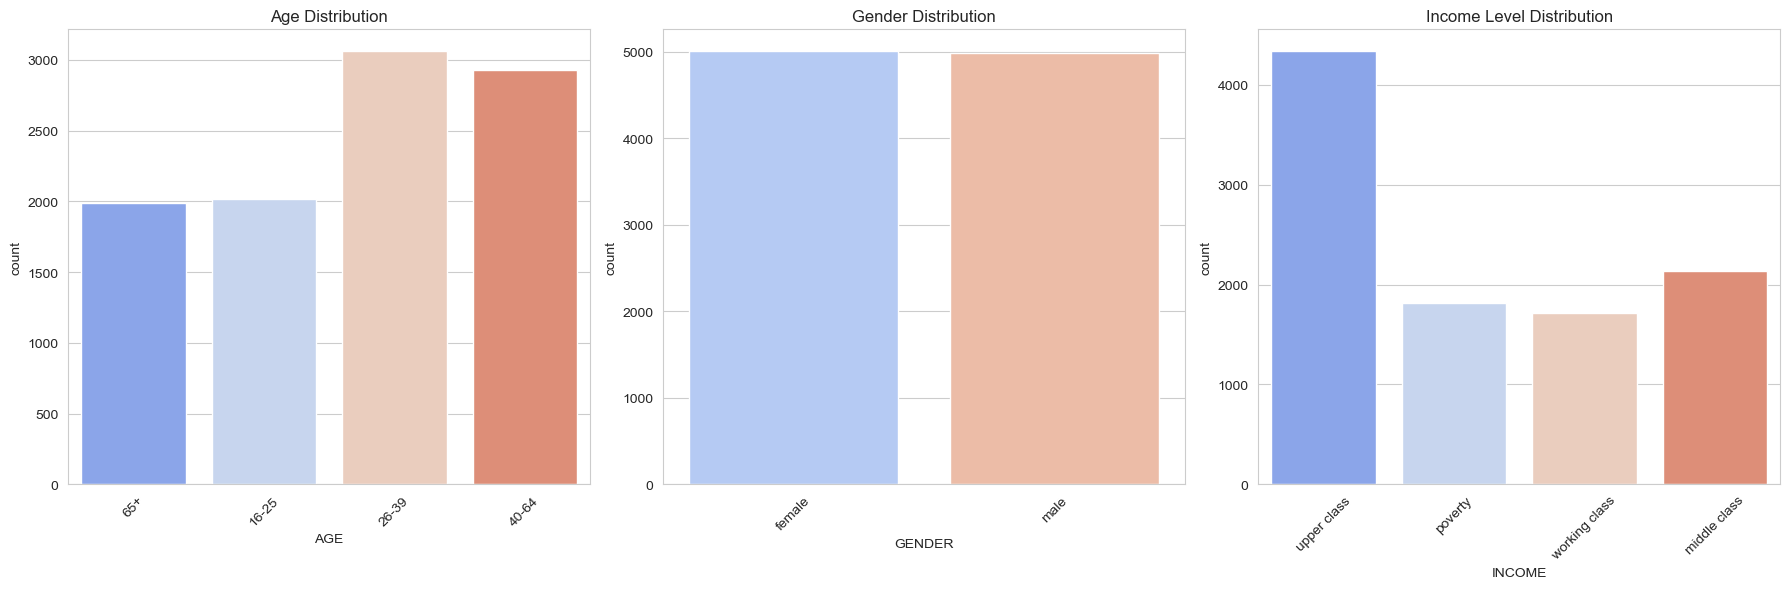

In [5]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Creating subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plotting distributions
sns.countplot(x='AGE', data=df, ax=axes[0], palette='coolwarm').set_title('Age Distribution')
sns.countplot(x='GENDER', data=df, ax=axes[1], palette='coolwarm').set_title('Gender Distribution')
sns.countplot(x='INCOME', data=df, ax=axes[2], palette='coolwarm').set_title('Income Level Distribution')

# Rotating x-axis labels for better readability
for ax in axes:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
plt.show();

Above we can see the distribution of the age, gender, and income level.

-   **Age Distribution:** The dataset contains a varied range of age groups, with representations across different categories.

-   **Gender Distribution:** There's a representation of both genders, allowing for analysis of gender-based trends in insurance claims.

-   **Income Level Distribution:** The dataset includes individuals from different income levels, ranging from poverty to upper class, which appears most prominent.ass.s.

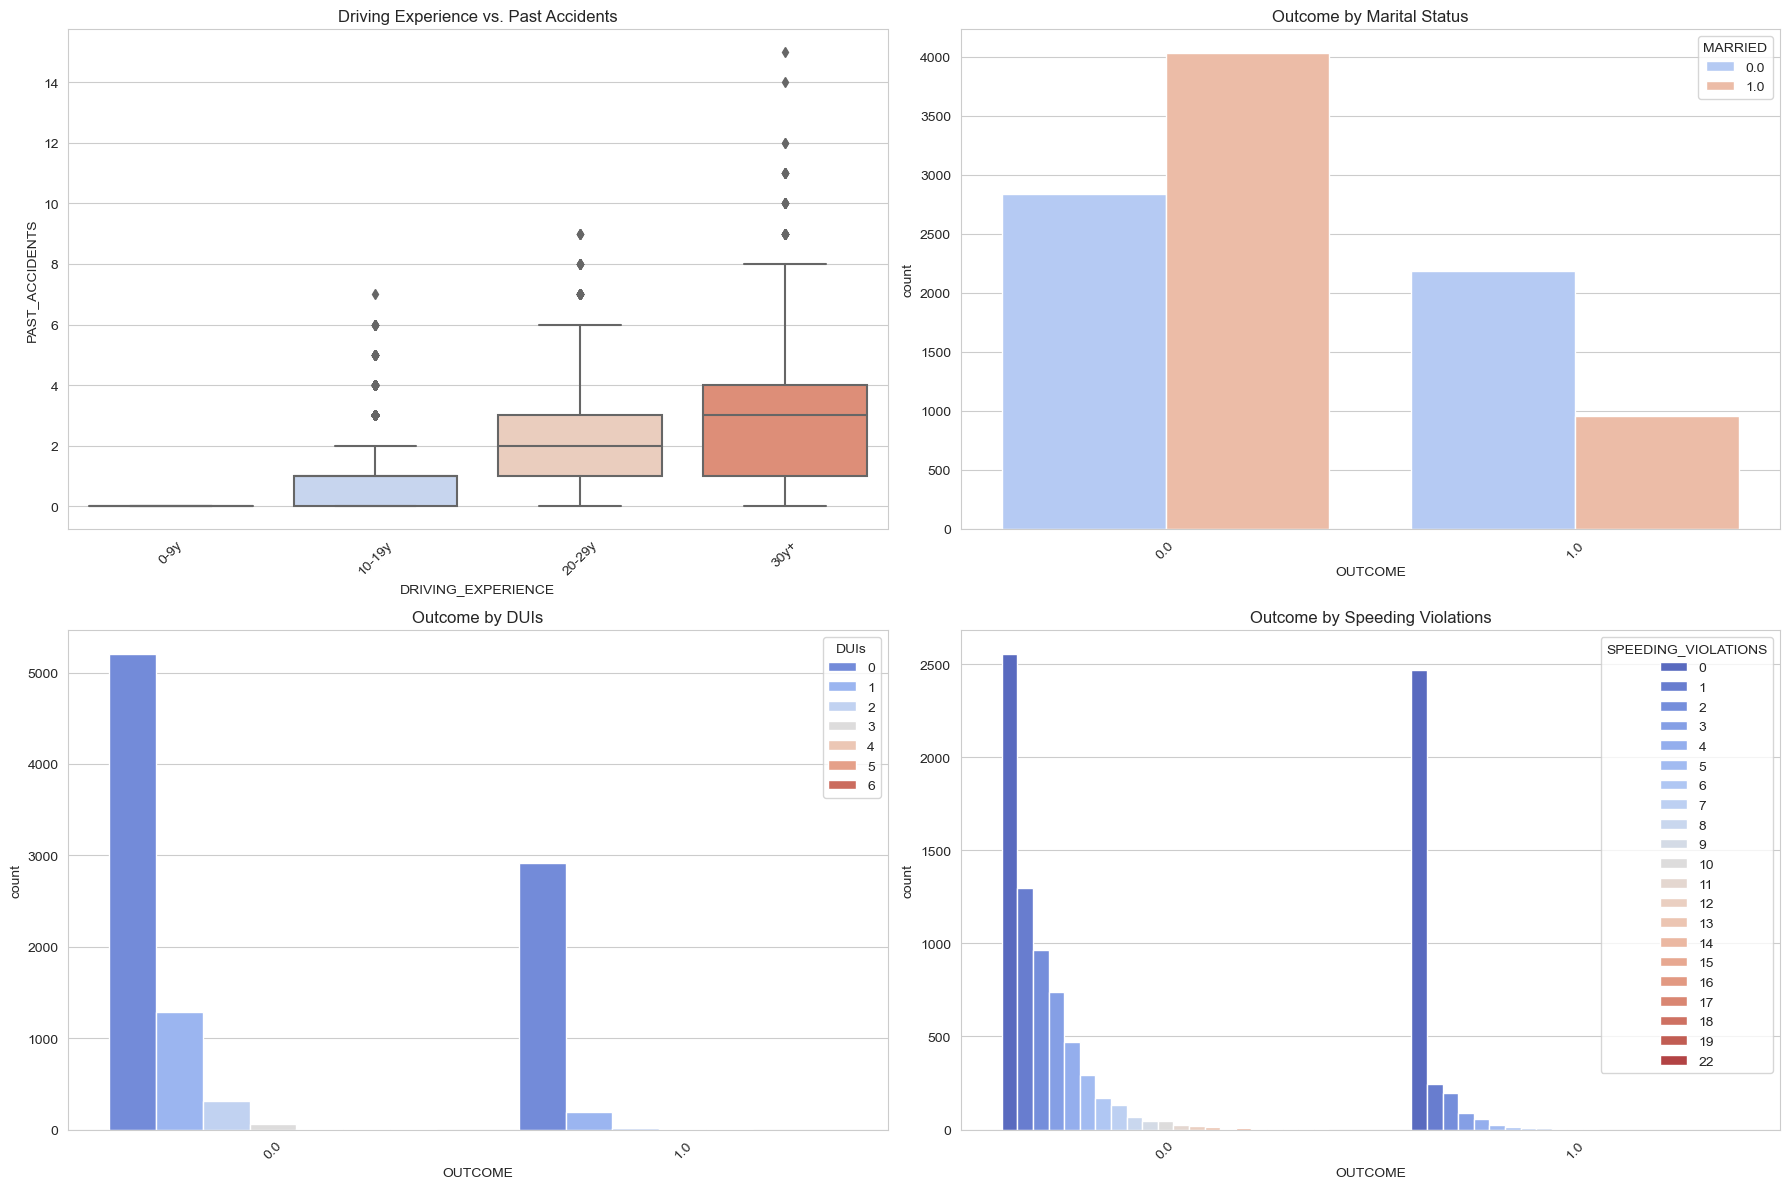

In [6]:
# Creating subplots for further analysis
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plotting relationship between driving experience and past accidents
sns.boxplot(x='DRIVING_EXPERIENCE', y='PAST_ACCIDENTS', data=df, ax=axes[0, 0], palette='coolwarm').set_title('Driving Experience vs. Past Accidents')

# Plotting outcome distribution by marital status
sns.countplot(x='OUTCOME', hue='MARRIED', data=df, ax=axes[0, 1], palette='coolwarm').set_title('Outcome by Marital Status')

# Plotting outcome distribution by DUIs
sns.countplot(x='OUTCOME', hue='DUIS', data=df, ax=axes[1, 0], palette='coolwarm').set_title('Outcome by DUIs')

# Adjusting legend for DUI plot to not overlap the bars
axes[1, 0].legend(title='DUIs', loc='upper right')

# Plotting outcome distribution by speeding violations
sns.countplot(x='OUTCOME', hue='SPEEDING_VIOLATIONS', data=df, ax=axes[1, 1], palette='coolwarm').set_title('Outcome by Speeding Violations')

# Rotating x-axis labels for better readability
for ax in axes[0]:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
for ax in axes[1]:
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
plt.show();

Above we can see some of the feature compared to the outcome, as well as the experience vs past accidents.

-   **Driving Experience vs. Past Accidents:** The boxplot shows the relationship between driving experience and past accidents, indicating how driving experience might correlate with the number of past accidents.

-   **Outcome by Marital Status:** This chart illustrates the distribution of insurance claim outcomes (claimed vs. not claimed) based on marital status, suggesting how marital status could influence claim outcomes
  .
-   **Outcome by DUIs:** The countplot shows the outcome distribution in relation to the number of DUIs, highlighting the impact of DUIs on insurance claim outcome
  s.
-   **Outcome by Speeding Violations:** This visualization presents the outcome distribution according to the number of speeding violations, offering insights into how speeding behavior might affect the likelihood of claiming insurance.

# Model the Data

In [7]:
df.head()

,ID,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
0,569520,65+,female,majority,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
1,750365,16-25,male,majority,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
2,199901,16-25,female,majority,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
3,478866,16-25,male,majority,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
4,731664,26-39,male,majority,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0


In [8]:
df['INCOME'].unique()

array(['upper class', 'poverty', 'working class', 'middle class'],
      dtype=object)

In [9]:
# Separating the target variable and features
X = df.drop(['ID', 'OUTCOME'], axis=1)
y = df['OUTCOME']

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Creating a preprocessing pipeline
scaler = StandardScaler()
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

ord_cols = ['AGE','DRIVING_EXPERIENCE','EDUCATION','INCOME']

age_order = ['16-25','26-39','40-64','65+']
de_order = ['0-9Y','10-19Y','20-29Y','30Y+']
ed_order = ['none','high school','university']
in_order = ['poverty','working class','middle class','upper class']

ord_encode = OrdinalEncoder(categories=[age_order,de_order,ed_order,in_order],handle_unknown='use_encoded_value', unknown_value=-1)
ord_scale = StandardScaler()

ord_pipe = make_pipeline(ord_encode, ord_scale)
ord_tup = ('ordinal',ord_pipe, ord_cols)

num_cols = X_train.select_dtypes('number').columns
num_impute = SimpleImputer(strategy='mean')
num_pipe = make_pipeline(num_impute,scaler)
num_tup = ('numeric', num_pipe, num_cols)

cat_cols = ['GENDER', 'RACE', 'VEHICLE_YEAR', 'VEHICLE_TYPE']
cat_tup = ('categorical', ohe, cat_cols)
preprocessor = ColumnTransformer(transformers =[
                                  num_tup,
                                  cat_tup,
                                  ord_tup],
                                  verbose_feature_names_out=False)

In [11]:
preprocessor.fit(X_train)

X_train_tf = preprocessor.transform(X_train)
X_test_tf = preprocessor.transform(X_test)

X_train_tf.head()

,CREDIT_SCORE,VEHICLE_OWNERSHIP,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,GENDER_female,...,RACE_majority,RACE_minority,VEHICLE_YEAR_after 2015,VEHICLE_YEAR_before 2015,VEHICLE_TYPE_sedan,VEHICLE_TYPE_sports car,AGE,DRIVING_EXPERIENCE,EDUCATION,INCOME
9254,0.232068,0.661480,0.997004,0.677143,-0.511636,-1.380365,1.111686,-0.433018,2.940435,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.466105,0.0,-0.279326,0.959008
1561,-1.177398,-1.511761,0.997004,0.677143,-0.511636,-1.006763,-0.661338,-0.433018,-0.642457,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,-0.478815,0.0,-1.633635,-1.655576
1670,0.158525,0.661480,0.997004,-1.476792,-0.511636,0.114044,-0.661338,-0.433018,-0.642457,1.0,...,0.0,1.0,0.0,1.0,1.0,0.0,-0.478815,0.0,1.074983,0.087480
6087,0.747562,0.661480,0.997004,-1.476792,0.685773,-1.006763,0.668430,-0.433018,-0.642457,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.493645,0.0,-0.279326,0.959008
6669,-0.314307,0.661480,-1.003005,-1.476792,0.685773,0.487647,-0.661338,-0.433018,-0.642457,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.493645,0.0,1.074983,0.087480


In [12]:
ranfor = RandomForestClassifier(random_state=42)

ran_pipe = make_pipeline(preprocessor, ranfor)
ran_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['CREDIT_SCORE', 'VEHICLE_OWNERSHIP', 'MARRIED', 'CHILDREN',
       'POSTAL_CODE', 'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS', 'DUIS',
       'PAST_ACCIDENTS'],
      dtype='object')),
                                                 ('categorical',
                                                  OneHotEnc...
                                                                                               '30Y+'],
                                                                                              ['none',
                                                                                               'high '
                                                                                               'school',
                                                                                               'university'],
                                                                                              ['poverty',
                                                                                               'working '
                                                                                               'class',
                                                                                               'middle '
                                                                                               'class',
                                                                                               'upper '
                                                                                               'class']],
                                                                                  handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1)),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['AGE', 'DRIVING_EXPERIENCE',
                                                   'EDUCATION', 'INCOME'])],
                                   verbose_feature_names_out=False)),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5500
         1.0       1.00      1.00      1.00      2500

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



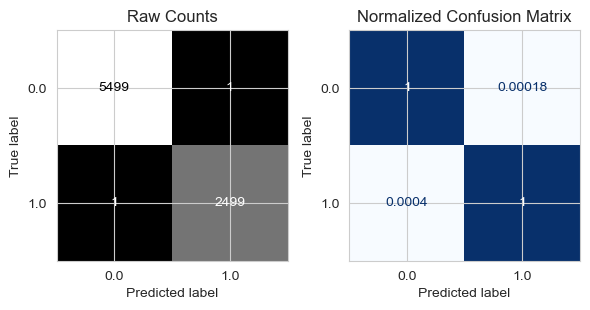


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.84      0.91      0.87      1367
         1.0       0.76      0.63      0.69       633

    accuracy                           0.82      2000
   macro avg       0.80      0.77      0.78      2000
weighted avg       0.81      0.82      0.81      2000



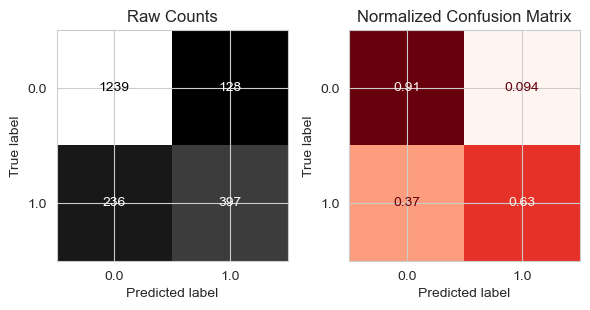

In [13]:
evaluate_classification(ran_pipe, X_train, y_train, X_test, y_test)

It looks like the model may be overfitting since the training data is 1 and the test data is 0.82.

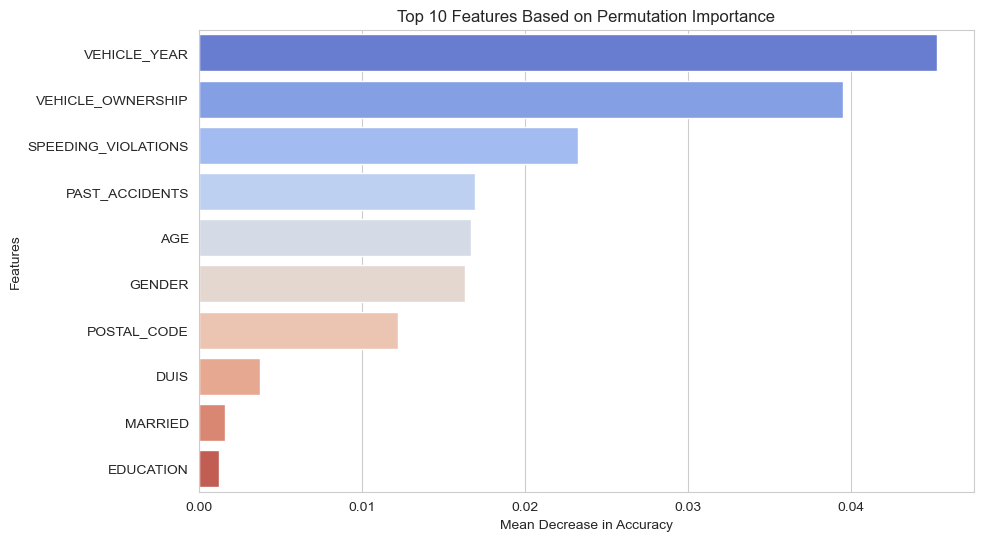

(Index(['VEHICLE_YEAR', 'VEHICLE_OWNERSHIP', 'SPEEDING_VIOLATIONS',
        'PAST_ACCIDENTS', 'AGE', 'GENDER', 'POSTAL_CODE', 'DUIS', 'MARRIED',
        'EDUCATION'],
       dtype='object'),
 array([0.04525, 0.0395 , 0.02325, 0.01695, 0.0167 , 0.0163 , 0.01225,
        0.00375, 0.0016 , 0.00125]))

In [14]:
# Calculate permutation importance on the test set
result = permutation_importance(ran_pipe, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Extract feature importances
importances = result.importances_mean

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Select the top 10 features
top_10_indices = indices[:10]
top_10_features = X.columns[top_10_indices]
top_10_importances = importances[top_10_indices]

# Plotting the top 10 features
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_importances, y=top_10_features, palette='coolwarm')
plt.title('Top 10 Features Based on Permutation Importance')
plt.xlabel('Mean Decrease in Accuracy')
plt.ylabel('Features')
plt.show()

top_10_features, top_10_importances

It would make sense that the model would look at newer vehicles so highly, possibly because fewer data showing they are involved in accidents, or possibly even the safety features make them less prone to accidents. 

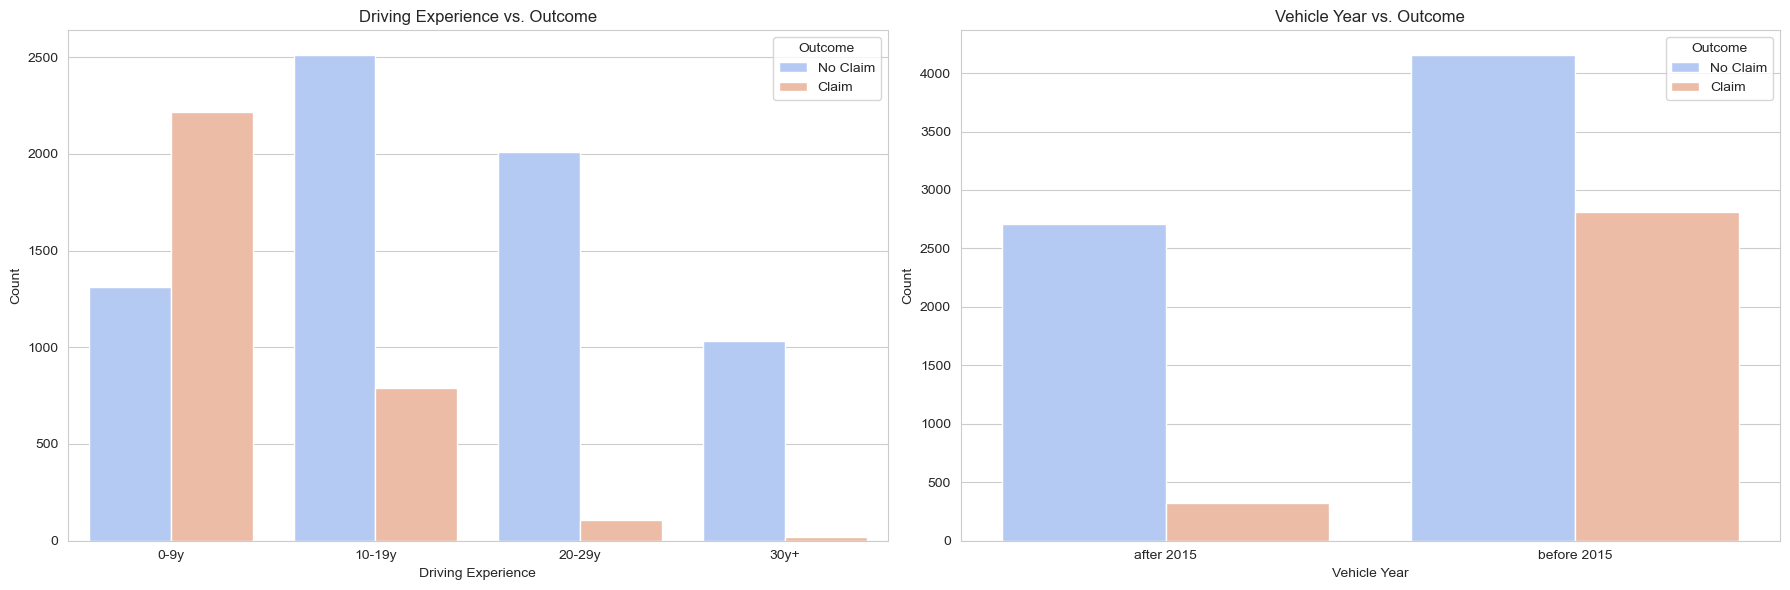

In [15]:
# Creating explanatory visualizations for "Driving Experience" and "Vehicle Year"

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Visualization for Driving Experience
sns.countplot(x='DRIVING_EXPERIENCE', hue='OUTCOME', data=df, ax=axes[0], palette='coolwarm')
axes[0].set_title('Driving Experience vs. Outcome')
axes[0].set_xlabel('Driving Experience')
axes[0].set_ylabel('Count')
axes[0].legend(title='Outcome', labels=['No Claim', 'Claim'])

# Visualization for Vehicle Year
sns.countplot(x='VEHICLE_YEAR', hue='OUTCOME', data=df, ax=axes[1], palette='coolwarm')
axes[1].set_title('Vehicle Year vs. Outcome')
axes[1].set_xlabel('Vehicle Year')
axes[1].set_ylabel('Count')
axes[1].legend(title='Outcome', labels=['No Claim', 'Claim'])

plt.tight_layout()
plt.show();

-   **Driving Experience vs. Outcome:** The visual illustrates how the likelihood of filing a claim varies across different levels of driving experience. It appears that individuals with less driving experience (0-9 years) have a higher count of claims compared to those with more experience. This trend suggests that as driving experience increases, the likelihood of filing a claim decreases, highlighting the importance of experience in reducing risk.

-   **Vehicle Year vs. Outcome:** This visualization shows the relationship between the age of the vehicle (categorized as "before 2015" and "after 2015") and claim outcomes. It indicates that vehicles before 2015 have a higher count of claims compared to vehicles after 2015. This might reflect on factors like older vehicles being more prone to issues leading to claims, or perhaps newer vehicles having better safety features that reduce the likelihood of claims.

# Apply PCA and Test Model

In [16]:
# Define PCA to address 95% of the variance
pca3 = PCA(n_components=3)

# fit and transform on training data
X_train_pca3 = pca3.fit_transform(X_train_tf)
# transform test data
X_test_pca3 = pca3.transform(X_test_tf)
# obtain the number of PCs used
pca3.n_components_

3

In [17]:
combined_train = pd.concat([X_train_pca3,X_train_tf],axis=1)
combined_test = pd.concat([X_test_pca3,X_test_tf],axis=1)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5500
         1.0       1.00      1.00      1.00      2500

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



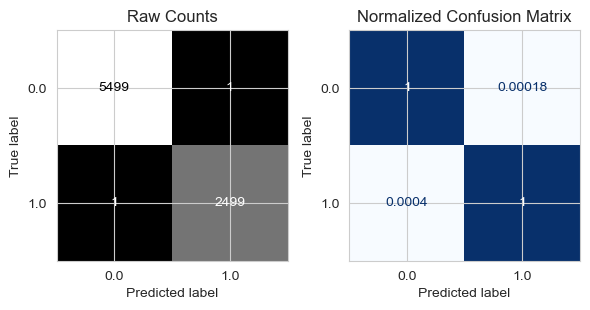


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.84      0.91      0.87      1367
         1.0       0.76      0.64      0.69       633

    accuracy                           0.82      2000
   macro avg       0.80      0.77      0.78      2000
weighted avg       0.82      0.82      0.82      2000



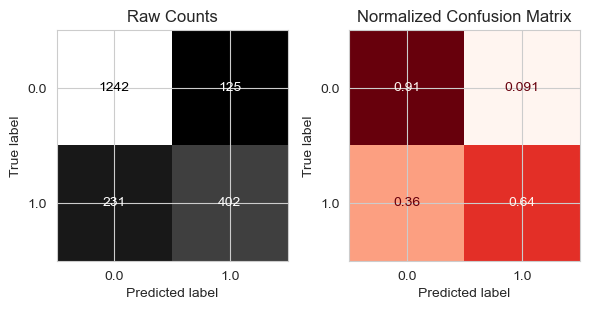

Training time was: 0:00:00.851161


In [18]:
# Record the start time
start = dt.datetime.now()

ranfor = RandomForestClassifier(random_state=42)
ranfor.fit(combined_train, y_train)

# Record the end time and calc duration
end = dt.datetime.now()
dur_pca_3 = end-start

evaluate_classification(ranfor, combined_train,y_train, combined_test, y_test)
print(f'Training time was: {dur_pca_3}')

        With PCA the model still is overfitting it appears as the accuracy is a perfect 1. However, the reduction to 3 from 19 columns has had no real impact on the accuracy as it stayed the same at 0.82.

# Adding Feature Selection to PCA and Model Test

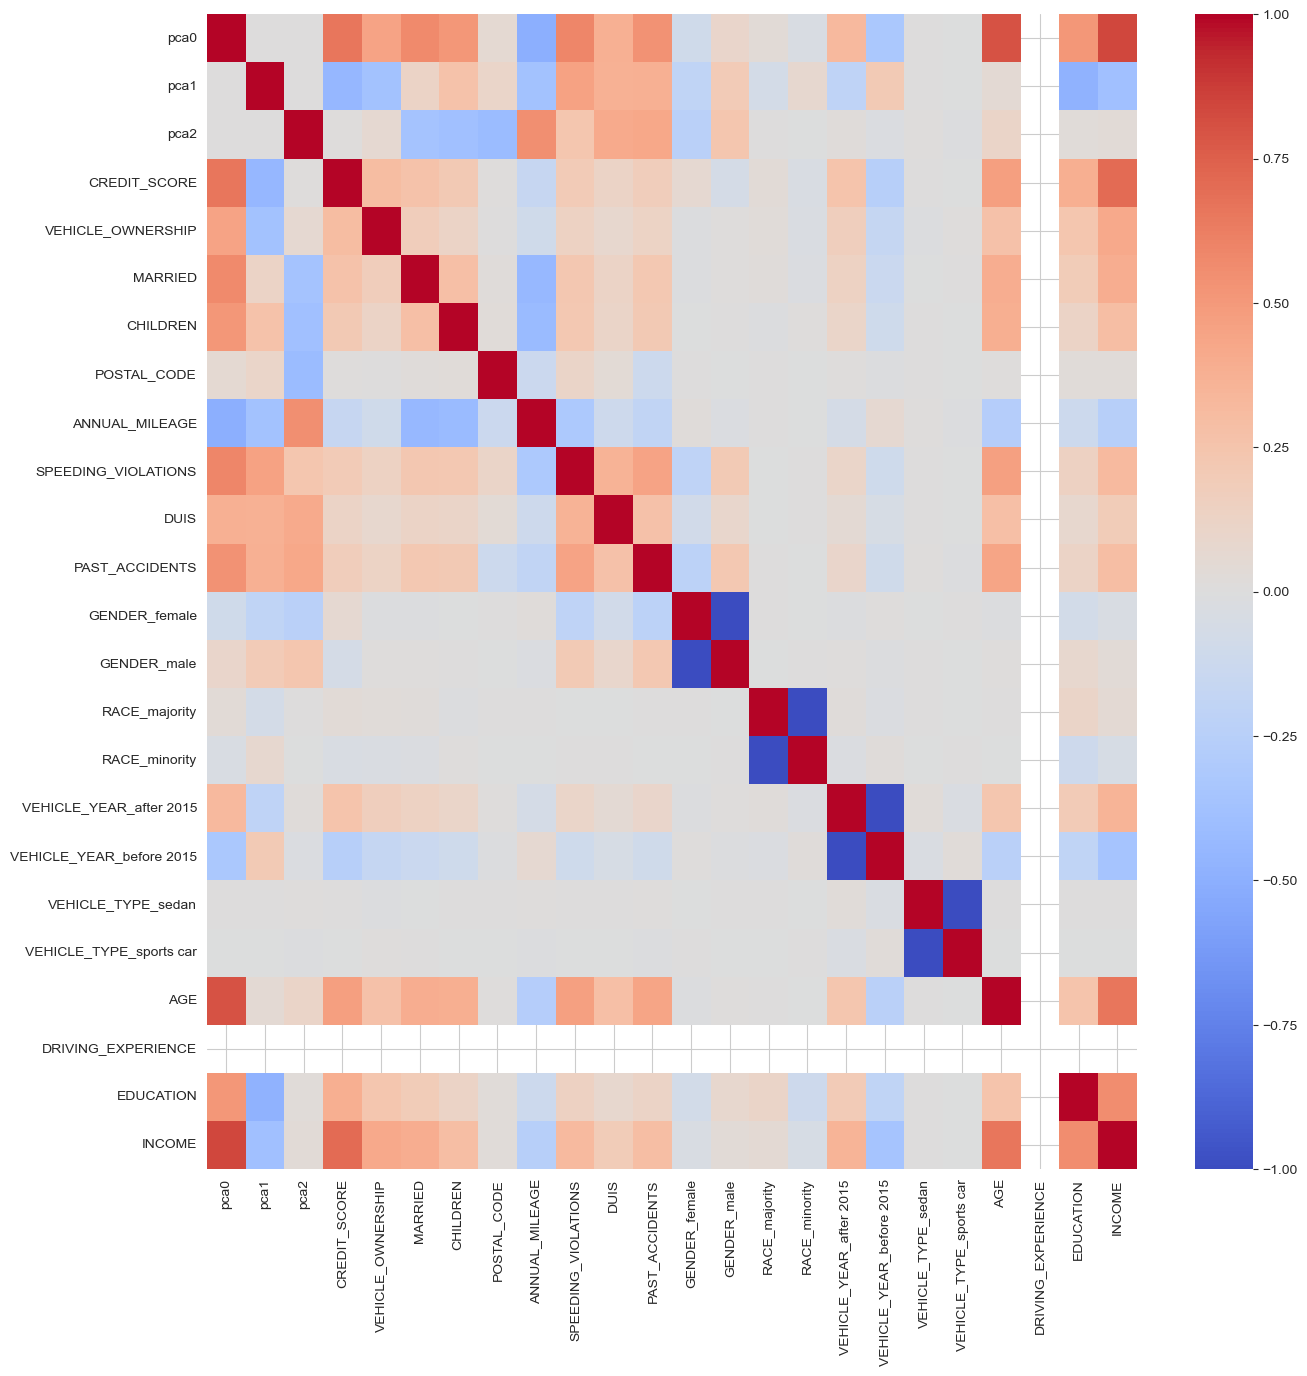

In [19]:
corr = combined_train.corr()

plt.figure(figsize=(15,15))
sns.heatmap(corr, cmap='coolwarm')
plt.show();

In [20]:
# Instantiate the selector, indicate theshold for r, also include the appropriate scoring metric for the task
selector = SelectNonCollinear(correlation_threshold = 0.75, scoring = f_classif)

In [21]:
# Fit on the training data, use .values
selector.fit(combined_train.values, y_train.values)

C:\Users\austi\anaconda3\envs\dojo-env\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [21] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\austi\anaconda3\envs\dojo-env\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
C:\Users\austi\anaconda3\envs\dojo-env\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\austi\anaconda3\envs\dojo-env\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [22]:
# Define a mask for filtering
non_collinear = selector.get_support()
non_collinear[:5]

[True, True, True, True, True]

In [23]:
# Check how many features are below the theshold
non_collinear.count(True)

17

In [24]:
# Check how many features are above the theshold
non_collinear.count(False)

7

In [25]:
# Filter training data
training_data_to_keep = combined_train.values[:, non_collinear]
# Filter column names
columns = np.array(combined_train.columns)[non_collinear]
# Make traing data into a dataframe
X_train_no_corr = pd.DataFrame(training_data_to_keep, columns = columns)

# Filter testing data
test_data_to_keep = combined_test.values[:, non_collinear]
# Make test data into a dataframe
X_test_no_corr = pd.DataFrame(test_data_to_keep, columns = columns)

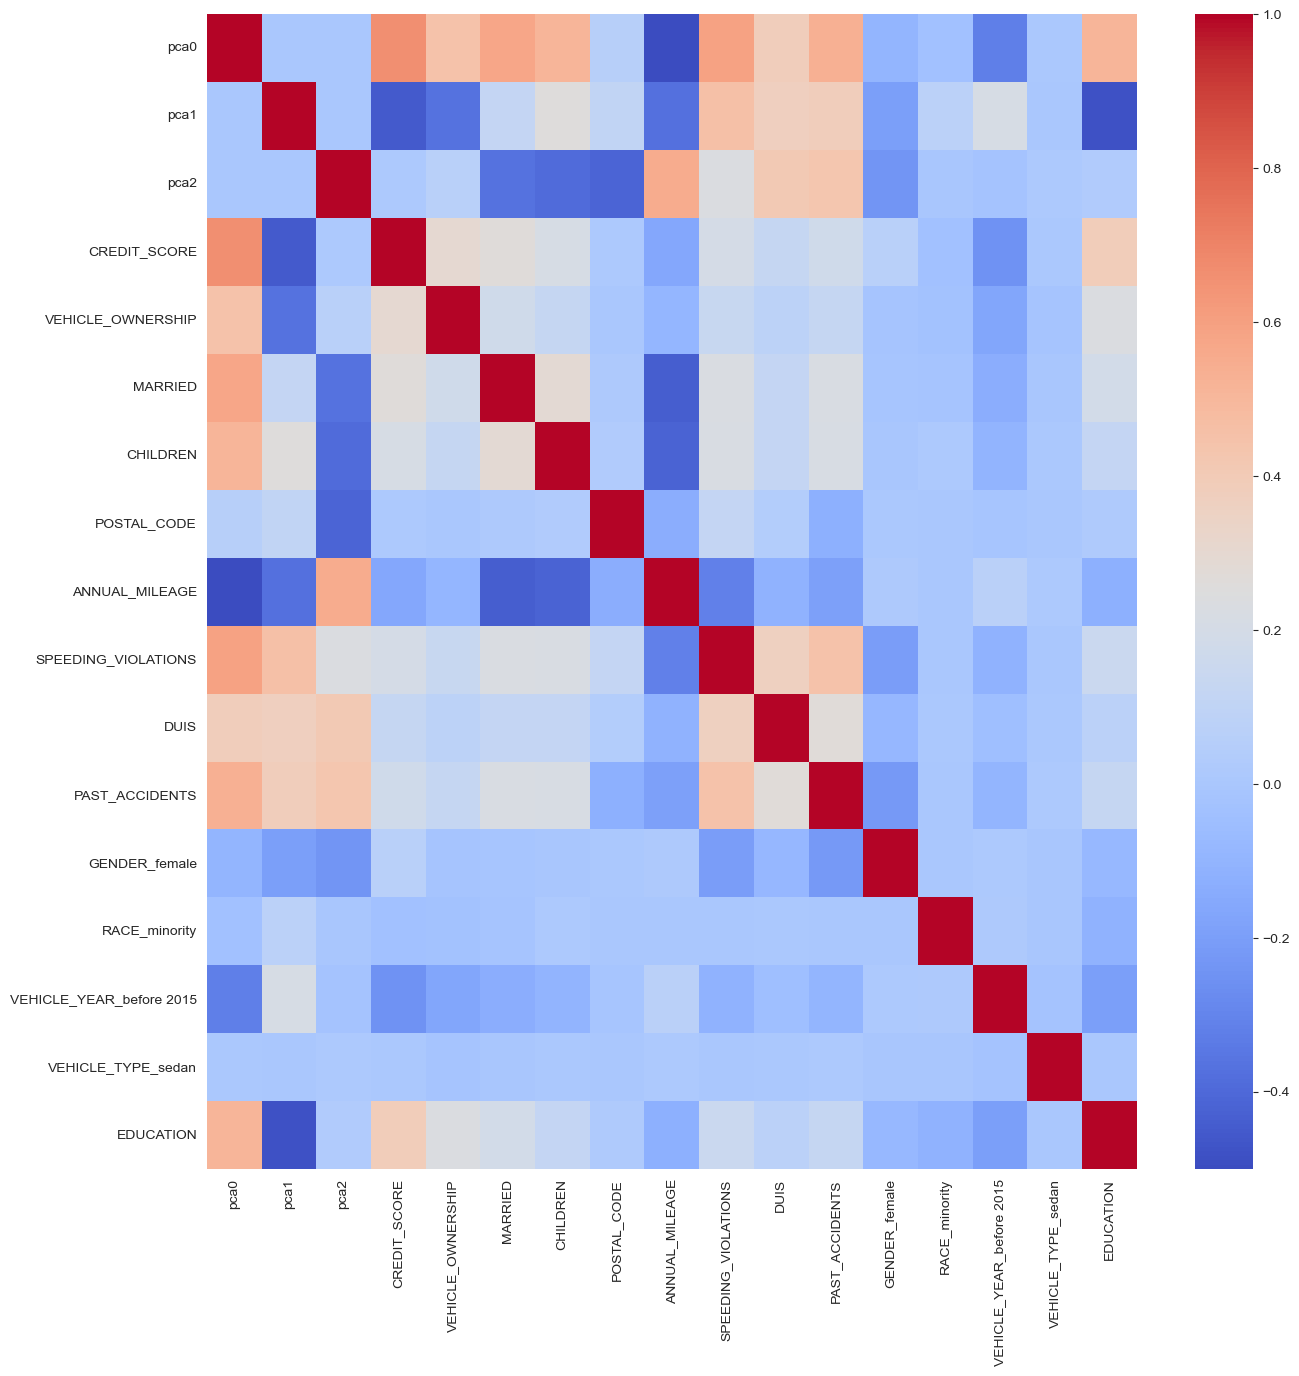

In [26]:
# Make correlation heatmap for non_collinear features
corr = X_train_no_corr.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr,cmap='coolwarm');

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5500
         1.0       1.00      1.00      1.00      2500

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



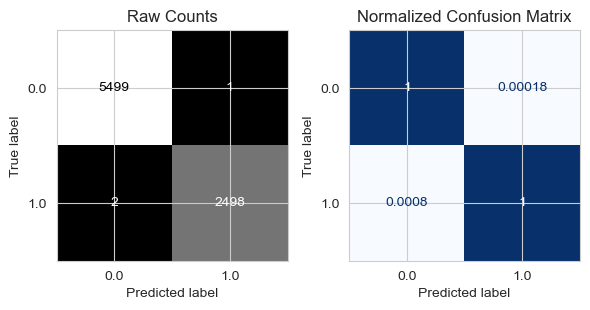


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.84      0.91      0.87      1367
         1.0       0.76      0.63      0.69       633

    accuracy                           0.82      2000
   macro avg       0.80      0.77      0.78      2000
weighted avg       0.82      0.82      0.82      2000



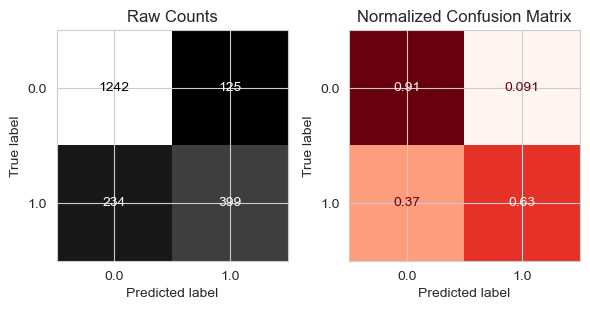

In [27]:
# Test the performance
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_no_corr, y_train)
evaluate_classification(rf_clf, X_train_no_corr, y_train, X_test_no_corr, y_test)

        Using the Correlation filter method, I reduced the features by 7, taking the dataset to 12 instead of 19.